In [10]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import fsolve
AllStockData = pd.read_csv('stockdata.csv', encoding='utf-8')
2317, 6505, 2002, 1449, 3562, 1704

In [64]:
StockList = [2317, 6505, 2002, 1449, 3562, 1704]
DataList = dict()
for i,j in enumerate(StockList):
    print(i)
    
    StockDataRaw = AllStockData[AllStockData['code']==StockList[i]][['code','date','close']]
    StockDataRaw.index = range(len(StockDataRaw))
    
    #===============================initial parameters===========================
    Mm = 10000000
    cash_ratio = 0.2
    M = Mm*(1-cash_ratio)
    Time = 3
    day_in_year = 252
    r = 0.013
    h = 1.1
    vol_day = 20
    #in_sample_last_year = 2012
    tc_buy = 0.001425
    tc_sell = 0.004425
    
    import numpy as np
    import math
    StockData = StockDataRaw
    StockData['lagClose'] = StockData['close'].shift(1)
    StockData['return'] = np.log(StockData['close']/StockData['lagClose'])
    StockData['vol'] = math.sqrt(252)*StockData['return'].rolling(vol_day).std()
    
    # in_sample_stock_data = StockData[StockData['date'] <= (in_sample_last_year*10000+1231)]
    # out_stock_data = StockData[StockData['date'] > (in_sample_last_year*10000+1231)]
    
    train_idx = range(int(len(StockData)*0.6))# 60% as training
    test_idx = range(int(len(StockData)*0.6), len(StockData)) # 40% as testing
    in_sample_stock_data = StockData.iloc[train_idx,: ]
    out_stock_data = StockData.iloc[test_idx,: ]
    
    out_stock_data.index = range(len(out_stock_data))
    
    in_time_sp = in_sample_stock_data['close'].quantile(0.3)
    
    in_position = np.amin(np.where(out_stock_data['close'] <= in_time_sp))
    
        
    
    out_stock_data1 = out_stock_data[in_position:]
    out_stock_data1 = out_stock_data1[0:(Time*day_in_year)]
    out_stock_data1.index = range(len(out_stock_data1))
    S = float(out_stock_data1['close'][0:1])
    vol=float(out_stock_data1['vol'][0:1])

    from scipy import stats
    rv = stats.norm(loc = 0, scale = 1)
    from scipy.optimize import fsolve

    def f(x) :
        y = [0,0]
        m = x[0]
        K = x[1]
        d1 = (np.log(S/K)+(r+0.5*vol**2)*Time)/(vol*np.sqrt(Time))
        d2 = d1-vol*np.sqrt(Time)
        y[0] = ( M*(1+h)/K-m )
        y[1] = (M-m*(S*norm.cdf(-d1)+K*np.exp(-r*Time)*norm.cdf(d2)))
        return y
    x0 = np.array([(M*(1+h)/(S * 1.1)), (S * 1.1)])
    x = fsolve(f, x0)

    print (x)

    m = x[0]
    K = x[1]

    out_stock_data1['Tt'] = np.arange(Time, 0, step = -1/(day_in_year)).tolist()
    out_stock_data1['d1'] = ((np.log(out_stock_data1['close']/K)+(r+0.5*out_stock_data1['vol']**2)*out_stock_data1['Tt'])/(out_stock_data1['vol']*out_stock_data1['Tt'].apply(np.sqrt)))
    out_stock_data1['stock_position'] = round(m*((-out_stock_data1['d1']).apply(rv.cdf))/1000)
    out_stock_data1['lag_stock_Position'] = out_stock_data1['stock_position'].shift(1)
    out_stock_data1['delta_Stock_Position'] = out_stock_data1['stock_position'] - out_stock_data1['lag_stock_Position']
    out_stock_data1['TC'] = np.nan
    out_stock_data1['Cash'] = np.nan
    out_stock_data1['Asset_value'] = np.nan
    out_stock_data1['Fund_Value'] = np.nan
    out_stock_data1['Net_Profit_Loss'] = np.nan
    out_stock_data1['Cum_Profit_Loss'] = np.nan
    out_stock_data1['delta_Stock_Position'][0] = float(out_stock_data1['stock_position'][0])

    for i in range(0,len(out_stock_data1)):
        if out_stock_data1['delta_Stock_Position'][i]>0:
            out_stock_data1['TC'][i] = np.round( np.abs(out_stock_data1['delta_Stock_Position'][i])*
                                               out_stock_data1['close'][i]*1000*tc_buy)

        else:
            out_stock_data1['TC'][i] = np.round( np.abs(out_stock_data1['delta_Stock_Position'][i])*
                                               out_stock_data1['close'][i]*1000*tc_sell)

    out_stock_data1['Asset_value'] = out_stock_data1['close']*out_stock_data1['stock_position']*1000
    out_stock_data1['Net_Profit_Loss'] = (out_stock_data1['close'] - out_stock_data1['lagClose'])*out_stock_data1['lag_stock_Position']*1000-out_stock_data1['TC']
    out_stock_data1['Net_Profit_Loss'][0] = (-out_stock_data1['TC'][0])
    out_stock_data1['Cum_Profit_Loss'] = np.cumsum(out_stock_data1['Net_Profit_Loss'])

    out_stock_data1['Cash'][0] = Mm*cash_ratio+M-out_stock_data1['stock_position'][0]*out_stock_data1['close'][0]*1000-out_stock_data1['TC'][0]
    out_stock_data1['Fund_Value'][0] = out_stock_data1['Cash'][0]+out_stock_data1['stock_position'][0]*out_stock_data1['close'][0]*1000

    for time_ind in range(1, len(out_stock_data1)):
        out_stock_data1['Cash'][time_ind] = out_stock_data1['Cash'][time_ind-1]-out_stock_data1['delta_Stock_Position'][time_ind]*out_stock_data1['close'][time_ind]*1000-out_stock_data1['TC'][time_ind]
        out_stock_data1['Fund_Value'][time_ind] = out_stock_data1['Cash'][time_ind]+out_stock_data1['Asset_value'][time_ind]

    import datetime
    type(datetime.date(2015, 1, 31))
    year = out_stock_data1['date']//10000
    month = (out_stock_data1['date']-(year * 10000))//100
    day = (out_stock_data1['date']-(year * 10000)-(month * 100))
    date = []
    for i in range(0,len(out_stock_data1)):
        Temp = datetime.date(year[i], month[i], day[i])
        date.append(Temp)

    out_stock_data1['Fund_Cum_return'] = out_stock_data1['Cum_Profit_Loss']/M
    out_stock_data1['Stock_Cum_return'] = np.cumprod(1+out_stock_data1['return']) - 1
    out_stock_data1['date'] = date
    Temp = out_stock_data1

    DataList[j] = Temp


0
[  4.17167206e+05   4.02716219e+01]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

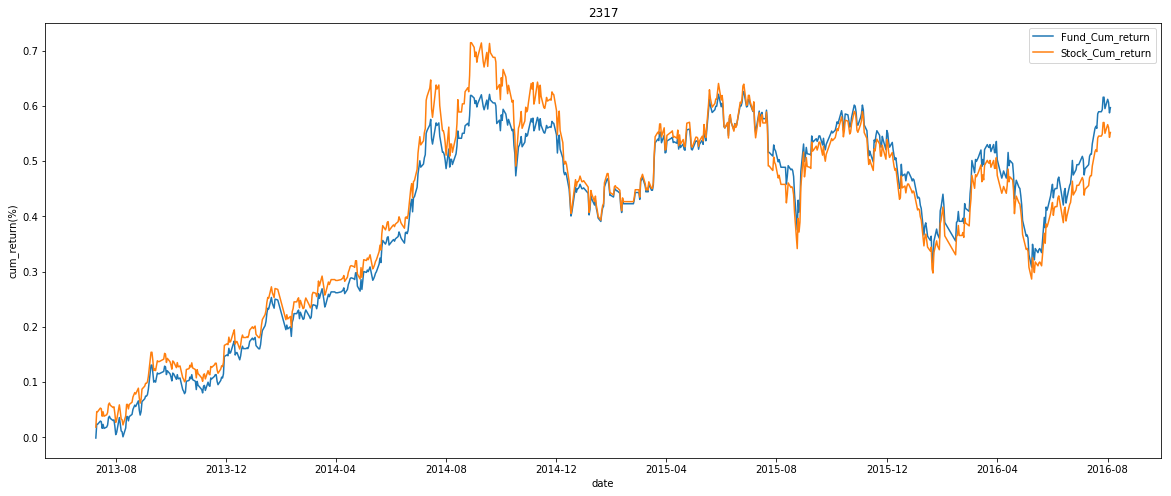

In [40]:
fund_data = DataList[2317]
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,8))

plt.plot(fund_data['date'], fund_data['Fund_Cum_return'], 
         label = 'Fund_Cum_return') 
plt.plot(fund_data['date'], fund_data['Stock_Cum_return'], 
         label = 'Stock_Cum_return') 

plt.title('{}'.format(fund_data['code'][0]))
plt.xlabel('date')
plt.ylabel('cum_return(%)')


plt.legend()

plt.show()

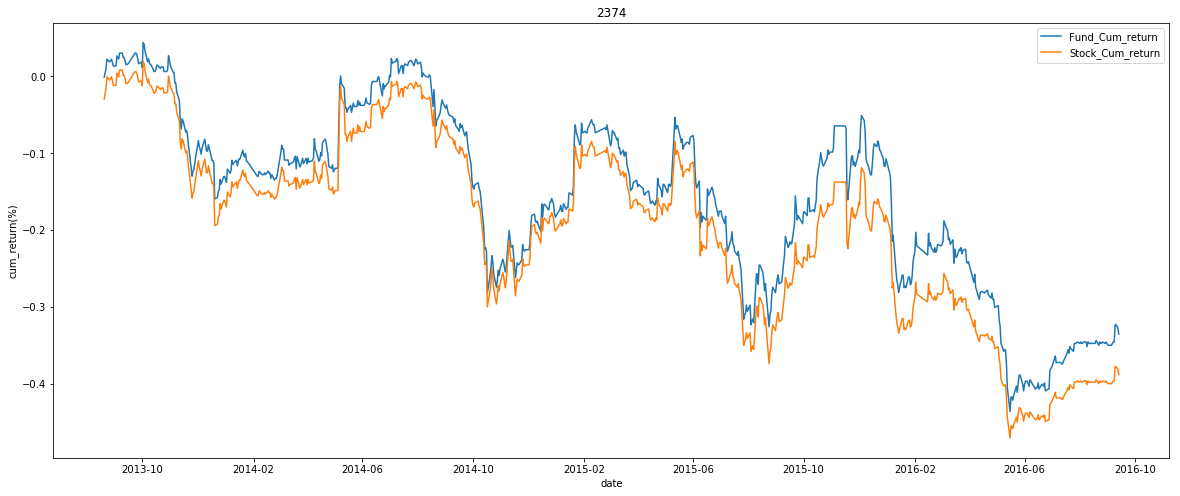

In [15]:
fund_data = DataList[2374]
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,8))

plt.plot(fund_data['date'], fund_data['Fund_Cum_return'], 
         label = 'Fund_Cum_return') 
plt.plot(fund_data['date'], fund_data['Stock_Cum_return'], 
         label = 'Stock_Cum_return') 

plt.title('{}'.format(fund_data['code'][0]))
plt.xlabel('date')
plt.ylabel('cum_return(%)')


plt.legend()

plt.show()

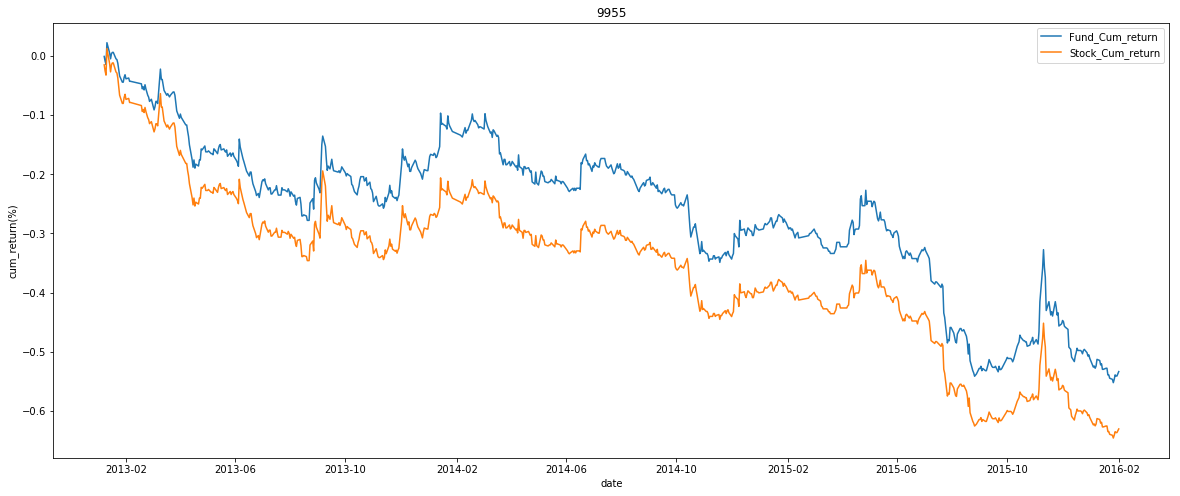

In [16]:
fund_data = DataList[9955]
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,8))

plt.plot(fund_data['date'], fund_data['Fund_Cum_return'], 
         label = 'Fund_Cum_return') 
plt.plot(fund_data['date'], fund_data['Stock_Cum_return'], 
         label = 'Stock_Cum_return') 

plt.title('{}'.format(fund_data['code'][0]))
plt.xlabel('date')
plt.ylabel('cum_return(%)')


plt.legend()

plt.show()

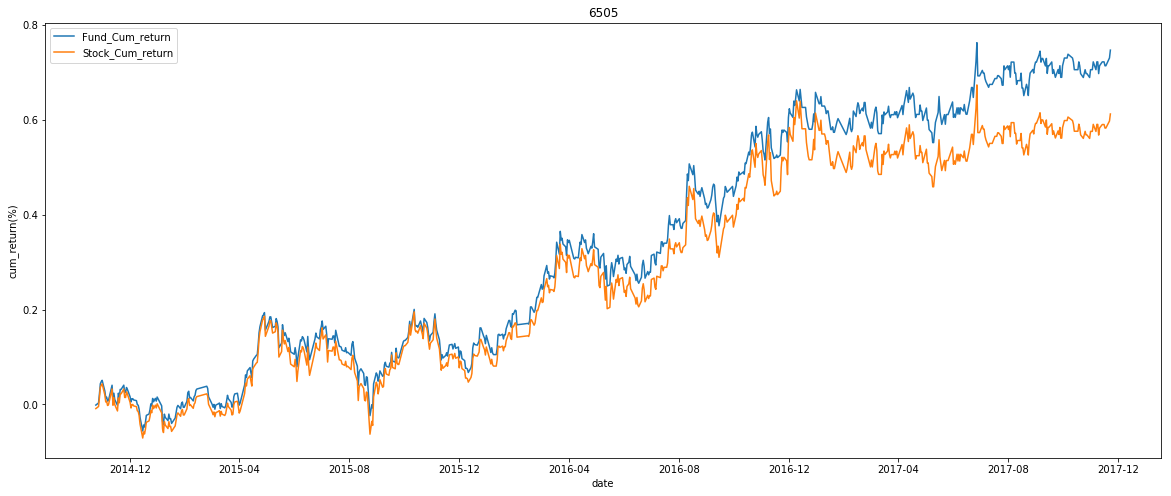

In [41]:
fund_data = DataList[6505]
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,8))

plt.plot(fund_data['date'], fund_data['Fund_Cum_return'], 
         label = 'Fund_Cum_return') 
plt.plot(fund_data['date'], fund_data['Stock_Cum_return'], 
         label = 'Stock_Cum_return') 

plt.title('{}'.format(fund_data['code'][0]))
plt.xlabel('date')
plt.ylabel('cum_return(%)')


plt.legend()

plt.show()

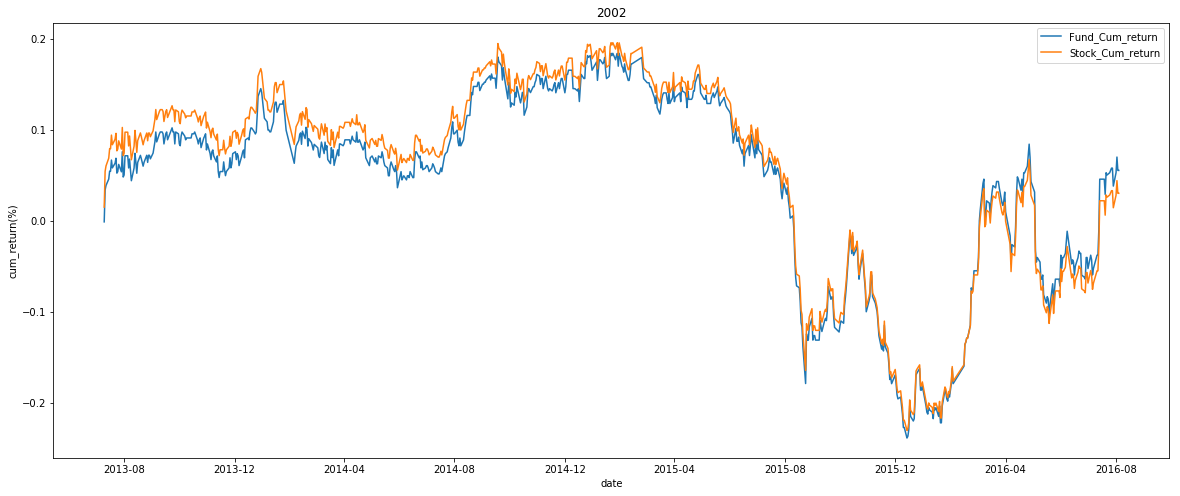

In [50]:
fund_data = DataList[2002]
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,8))

plt.plot(fund_data['date'], fund_data['Fund_Cum_return'], 
         label = 'Fund_Cum_return') 
plt.plot(fund_data['date'], fund_data['Stock_Cum_return'], 
         label = 'Stock_Cum_return') 

plt.title('{}'.format(fund_data['code'][0]))
plt.xlabel('date')
plt.ylabel('cum_return(%)')


plt.legend()

plt.show()

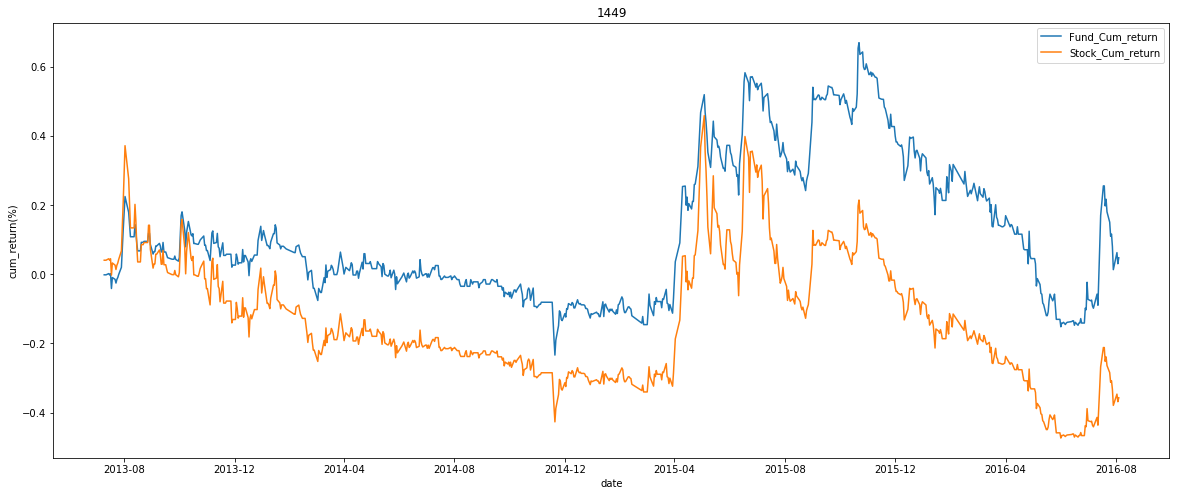

In [58]:
fund_data = DataList[1449]
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,8))

plt.plot(fund_data['date'], fund_data['Fund_Cum_return'], 
         label = 'Fund_Cum_return') 
plt.plot(fund_data['date'], fund_data['Stock_Cum_return'], 
         label = 'Stock_Cum_return') 

plt.title('{}'.format(fund_data['code'][0]))
plt.xlabel('date')
plt.ylabel('cum_return(%)')


plt.legend()

plt.show()

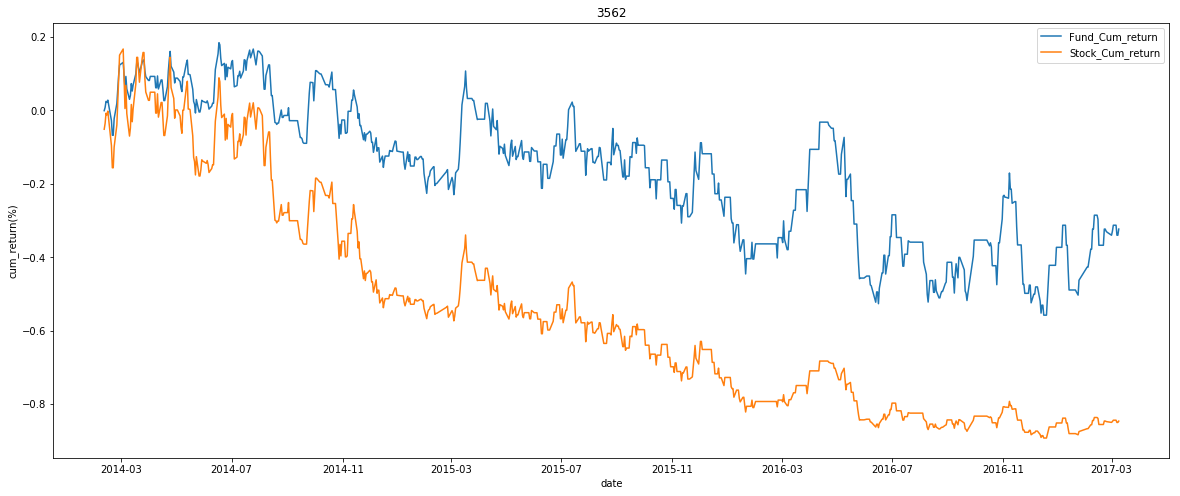

In [62]:
fund_data = DataList[3562]
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,8))

plt.plot(fund_data['date'], fund_data['Fund_Cum_return'], 
         label = 'Fund_Cum_return') 
plt.plot(fund_data['date'], fund_data['Stock_Cum_return'], 
         label = 'Stock_Cum_return') 

plt.title('{}'.format(fund_data['code'][0]))
plt.xlabel('date')
plt.ylabel('cum_return(%)')


plt.legend()

plt.show()

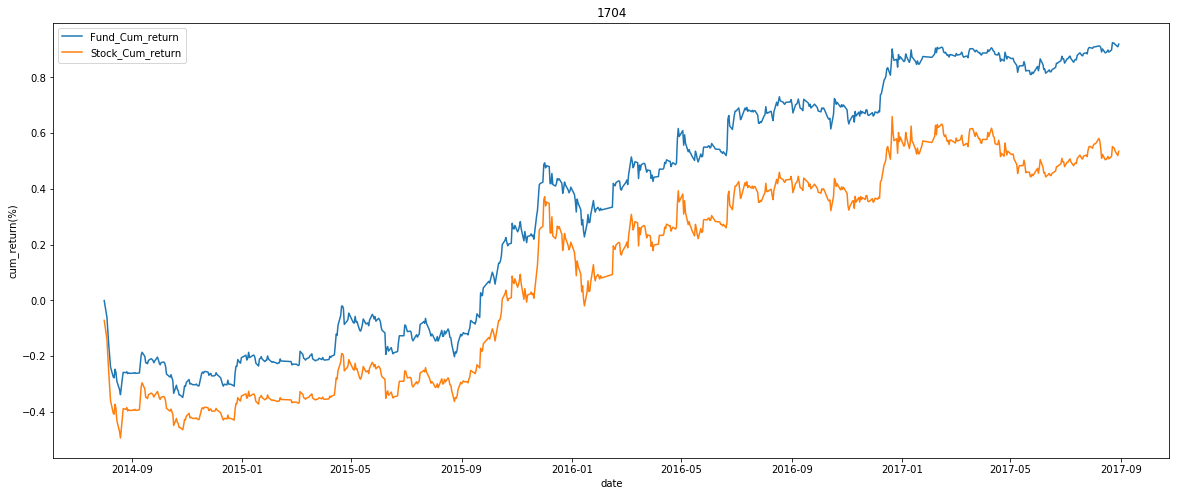

In [65]:
fund_data = DataList[1704]
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,8))

plt.plot(fund_data['date'], fund_data['Fund_Cum_return'], 
         label = 'Fund_Cum_return') 
plt.plot(fund_data['date'], fund_data['Stock_Cum_return'], 
         label = 'Stock_Cum_return') 

plt.title('{}'.format(fund_data['code'][0]))
plt.xlabel('date')
plt.ylabel('cum_return(%)')


plt.legend()

plt.show()